Please take 48 hours to solve it if you can. If it is too far outside of your comfort level we will understand completely. Just let us know.

What we are testing here:
Coding skills
AI skills - does the candidate understand **when to use neural networks and when not to use neural networks.**
Modeling and experimentation - The candidate knows how to improve the solutions by **selecting the right models**. 
Explainability - Can the candidate clearly **explain their solution**.
Can the candidate look at related work (in this case other kernels on Kaggle) and build their own solution.

Problem Statement: A Kaggle competition for a multi-class classification problem on text data - each text sample can belong to various classes. You must **create a model which predicts the probability of each class for each text sample.** The details can be found here - https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

Data: You can use the training data provided in the Kaggle link. You may use a subset of data if you feel the data is too large. You can also split the data into training and validation sets. 

Metrics:  You can choose to use the metric provided in the contest or you can use any other metric which you feel is suitable. 

Challenge:  
Design a classification system **using the traditional NLP techniques** - for instance - stop word removal, stemming... etc -  followed by **a standard ML algorithm like Trees**. 
Design a classification system using **Neural Networks - CNN, LSTM' s**, etc - whichever you feel is relevant. 

What we want to see:
**Two python notebooks (one for task 1 and one for task 2) with detailed explanations about the approach with comments wherever required.** The code has to be clean and easy to understand. You don't need to provide additional documentation - the notebook itself should be self-explanatory (with comments and explanation). We might have a follow-up about the solution or the approach you came up with.

We **don't want you to use the existing kernel on Kaggle.** You can use them as a reference for your solution. 
You can use any libraries for your solution. Also, you can use free GPU's (on Colab or any other source) to train your model. 

Please send us the two notebook files within 48 hours of receiving the challenge (which is this email itself).

- Challenge 2 / Task 2 is optional. However, if you complete it, you would have a higher score compared to the rest of the candidates. 


In [1]:
import re
import numpy as np
import pandas as pd
import random
from pprint import pprint

import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()  # don't skip this

import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Training Models

In [2]:
df = pd.read_csv("dataSet/train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
# Create new culumn inicating total number of categories per comment
df['sum'] = df['toxic']+df['severe_toxic']+df['obscene']+df['threat']+df['insult']+df['identity_hate']

In [4]:
# sampling the neutral comments to have a relatively balanced dataset to create corpus
df['sum'].value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: sum, dtype: int64

In [5]:
toxic_counts = sum(df['sum'].value_counts()[1:])

idx_neu = df['sum'][df['sum'] == 0 ].sample(toxic_counts).index
df_neu = df.loc[idx_neu]

df_tox = df[df['sum'] != 0]

df_sample = df_tox.append(df_neu, ignore_index=0)

In [6]:
df_sample.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,4
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,3


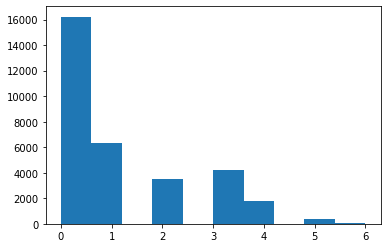

In [7]:
_ = plt.hist(df_sample['sum'])

In [8]:
data = df_sample.comment_text.values.tolist()
print(data[-1])
print(df_sample.iloc[-1,:])

Great, so what's next?
id                     4f76fced4d490f3d
comment_text     Great, so what's next?
toxic                                 0
severe_toxic                          0
obscene                               0
threat                                0
insult                                0
identity_hate                         0
sum                                   0
Name: 29922, dtype: object


In [9]:
data_tox = df_sample[df_sample['sum']!=0].comment_text.values.tolist()
print(data_tox[0])
print(df_sample.iloc[0,:])

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
id                                           0002bcb3da6cb337
comment_text     COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
toxic                                                       1
severe_toxic                                                1
obscene                                                     1
threat                                                      0
insult                                                      1
identity_hate                                               0
sum                                                         4
Name: 6, dtype: object


### Binary Classification

In [10]:
#Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True: removes punctuations

In [11]:
data_words = list(sent_to_words(data))

In [12]:
print(data_words[-1])

['great', 'so', 'what', 'next']


In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams) #, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [16]:
print(data_lemmatized[:1])

[['piss', 'work']]


In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [18]:
# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


[[('around', 1), ('cocksucker', 1), ('piss', 1), ('work', 1)]]

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2,
                                           random_state=0)

In [20]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())

[(0,
  '0.014*"oh_bob" + 0.014*"bob_saget" + 0.014*"saget_oh" + 0.011*"lol_lol" + '
  '0.009*"fuck" + 0.007*"go" + 0.006*"tacos_tacos" + 0.004*"know" + '
  '0.004*"get" + 0.004*"hate"'),
 (1,
  '0.011*"article" + 0.010*"wikipedia" + 0.010*"page" + 0.007*"talk" + '
  '0.006*"please" + 0.006*"one" + 0.006*"like" + 0.005*"would" + 0.004*"see" + '
  '0.004*"also"')]


In [21]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.83488092612311

Coherence Score:  0.5863203162774752


In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/Users/tegochang/opt/miniconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/tegochang/opt/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tegochang/opt/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tegochang/opt/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tegochang/opt/m

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.180184  0.0       1        1  82.055375
0     -0.180184  0.0       2        1  17.944625, topic_info=            Term         Freq        Total Category  logprob  loglift
61800     oh_bob  2472.000000  2472.000000  Default  30.0000  30.0000
61799  bob_saget  2445.000000  2445.000000  Default  29.0000  29.0000
61802   saget_oh  2445.000000  2445.000000  Default  28.0000  28.0000
2106     lol_lol  1916.000000  1916.000000  Default  27.0000  27.0000
97          fuck  1585.000000  1585.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2854    org_wiki   234.966988   383.759596   Topic2  -6.5992   1.2273
256    wikipedia   572.797920  8733.391684   Topic2  -5.7081  -1.0065
445         dont   221.837662   479.329945   Topic2  -6.6567   0.9474
252         want   250.496534  1833.963609   Topic2  -6.5352  -0.2729
21           one   255.750828  4724.458336   Topic2  -6.5144  -1.1984

[166 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
440        1  0.994576          add
440        2  0.005242          add
33690      2  0.998130    aids_aids
311        1  0.982073         also
311        2  0.017734         also
...      ...       ...          ...
91         2  0.010099        would
30         1  0.998185           wp
30         2  0.002085           wp
33195      2  0.999567  youbollocks
21818      2  1.000287   yourselfgo

[237 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [23]:
df_sample[df_sample['sum'] != 0]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,4
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,3
...,...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,4
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,2
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,3
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0,2


In [24]:
# predicting comment which is in dataframe  
new_text_corpus =  id2word.doc2bow(df_sample['comment_text'][159554].split())
lda_model[new_text_corpus]

[(0, 0.55616134), (1, 0.44383872)]

### Multi-class Classification

In [25]:
data_words_tox = list(sent_to_words(data_tox))

In [26]:
print(data_words_tox[-1])

['and', 'going', 'to', 'keep', 'posting', 'the', 'stuff', 'deleted', 'until', 'this', 'fucking', 'site', 'closes', 'down', 'have', 'fun', 'stupid', 'ass', 'bitch', 'don', 'ever', 'delete', 'anything', 'fuckin', 'hore', 'like', 'said', 'before', 'go', 'to', 'hell']


In [27]:
# Build the bigram and trigram models
bigram_tox = gensim.models.Phrases(data_words_tox, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_tox = gensim.models.Phrases(bigram[data_words_tox], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod_tox = gensim.models.phrases.Phraser(bigram_tox)
trigram_mod_tox = gensim.models.phrases.Phraser(trigram_tox)

In [28]:
# Remove Stop Words
data_words_tox_nostops = remove_stopwords(data_words_tox)

# Form Bigrams
data_words_tox_bigrams = make_bigrams(data_words_tox_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_tox_lemmatized = lemmatization(data_words_tox_bigrams) #, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [29]:
print(data_tox_lemmatized[:1])

[['piss', 'work']]


In [30]:
# Create Dictionary
id2word_tox = corpora.Dictionary(data_words_tox_bigrams)

# Create Corpus
texts_tox = data_words_tox_bigrams

# Term Document Frequency
corpus_tox = [id2word_tox.doc2bow(text) for text in texts_tox]

In [31]:
# View
print(corpus_tox[:1])

# Human readable format of corpus (term-frequency)
[[(id2word_tox[id], freq) for id, freq in cp] for cp in corpus_tox[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


[[('around', 1), ('cocksucker', 1), ('piss', 1), ('work', 1)]]

In [32]:
# Build LDA model
lda_model_tox = gensim.models.ldamodel.LdaModel(corpus=corpus_tox,
                                           id2word=id2word_tox,
                                           num_topics=6,
                                           random_state=0)

In [33]:
# Print the Keyword in the topics
pprint(lda_model_tox.print_topics())

[(0,
  '0.138*"fuck" + 0.036*"ass" + 0.035*"fucking" + 0.032*"go" + '
  '0.029*"vagina_vagina" + 0.028*"bitch" + 0.025*"gay" + 0.018*"mother" + '
  '0.017*"wikipedia" + 0.017*"nigger"'),
 (1,
  '0.009*"wikipedia" + 0.009*"like" + 0.009*"people" + 0.009*"get" + '
  '0.007*"one" + 0.006*"fucking" + 0.006*"know" + 0.005*"think" + '
  '0.005*"stupid" + 0.005*"article"'),
 (2,
  '0.089*"hate" + 0.031*"fat_jew" + 0.028*"cunt" + 0.024*"jew_fat" + '
  '0.021*"nipple_nipple" + 0.021*"moron_hi" + 0.014*"sucks_cocks" + '
  '0.012*"nigger_nigger" + 0.009*"fucking_cocksucking" + 0.009*"shit_cunts"'),
 (3,
  '0.027*"shit" + 0.018*"page" + 0.014*"like" + 0.012*"talk" + 0.012*"semen" + '
  '0.008*"stop" + 0.007*"user" + 0.006*"wikipedia" + 0.006*"going" + '
  '0.006*"get"'),
 (4,
  '0.062*"suck" + 0.028*"chuck_norris" + 0.024*"mouth" + 0.021*"die" + '
  '0.018*"shut" + 0.017*"know" + 0.016*"dont_care" + 0.015*"dick" + '
  '0.015*"cock" + 0.013*"cocksucker"'),
 (5,
  '0.030*"asshole" + 0.028*"dickhead"

In [34]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_tox.log_perplexity(corpus_tox))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_tox = CoherenceModel(model=lda_model_tox, texts=data_words_tox_bigrams, dictionary=id2word_tox, coherence='c_v')
coherence_lda_tox = coherence_model_lda_tox.get_coherence()
print('\nCoherence Score: ', coherence_lda_tox)


Perplexity:  -8.43442768477533

Coherence Score:  0.636033133495919


In [35]:
# Visualize the topics
# pyLDAvis.enable_notebook()
vis_tox = gensimvis.prepare(lda_model_tox, corpus_tox, id2word_tox)
vis_tox

/Users/tegochang/opt/miniconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.176400 -0.069044       1        1  46.210245
3     -0.163721 -0.065080       2        1  21.049852
0     -0.028221  0.258475       3        1  12.263270
4     -0.029589 -0.027170       4        1   7.930834
2      0.178244 -0.120784       5        1   6.290824
5      0.219687  0.023602       6        1   6.254975, topic_info=                          Term         Freq        Total Category  logprob  \
97                        fuck  7450.000000  7450.000000  Default  30.0000   
363                       hate  2335.000000  2335.000000  Default  29.0000   
827                       suck  2092.000000  2092.000000  Default  28.0000   
94                         ass  1867.000000  1867.000000  Default  27.0000   
57                          go  2517.000000  2517.000000  Default  26.0000   
...                        ...          ...          ...      ...      ...   
31430  criminalwar_criminalwar   113.789418   138.489142   Topic6  -5.4350   
119                        get   241.577661  2685.661609   Topic6  -4.6821   
1198                    fuckin   131.108697   345.082589   Topic6  -5.2933   
506                     person   139.477942   597.803768   Topic6  -5.2314   
97                        fuck   188.976500  7450.148511   Topic6  -4.9277   

       loglift  
97     30.0000  
363    29.0000  
827    28.0000  
94     27.0000  
57     26.0000  
...        ...  
31430   2.5754  
119     0.3633  
1198    1.8040  
506     1.3164  
97     -0.9026  

[393 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
4541       3  0.985034       absurd
927        1  0.979275       access
928        1  0.864509     actually
928        2  0.075054     actually
928        3  0.022238     actually
...      ...       ...          ...
91         6  0.004233        would
33195      6  0.995621  youbollocks
21818      3  0.994430   yourselfgo
3689       1  0.973395      zionist
3689       2  0.013710      zionist

[986 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 3, 6])

In [36]:
df_sample[df_sample['sum'] != 0]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,4
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,3
...,...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,4
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,2
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,3
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0,2


In [37]:
# predicting comment which is in dataframe  
new_text_corpus_tox =  id2word_tox.doc2bow(df_sample['comment_text'][159494].split())
lda_model_tox[new_text_corpus_tox]

[(0, 0.3402183),
 (1, 0.47162488),
 (2, 0.0105529),
 (3, 0.12528099),
 (4, 0.043037992)]

## Evaluating Model Generalization Performance

In [38]:
df_test = pd.read_csv("dataSet/test.csv")
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
